# wave - eddy interactions - the vertical fluxes

The equation describing the rate of change of total $E$ energy for a QG mean flow $\pmb{u}$, and internal wave perterbations $\pmb{u}^\prime$, is the following:

$$(\frac{\partial}{\partial t}  + \overline{\pmb{u}} \cdot \nabla) E + \nabla \cdot {\overline{\phi^\prime \pmb{u}^\prime}} = - \frac{1}{2} (\overline{u^\prime u^\prime} - \overline{\upsilon^\prime \upsilon^\prime}) S_n - \overline{u^\prime \upsilon^\prime} S_s - (\overline{u^\prime w^\prime} - f N^{-2} \overline{b^\prime \upsilon^\prime}) \frac{\partial \overline{u}}{\partial z} - ( \overline{\upsilon^\prime w^\prime} + f N^{-2} \overline{b^\prime u^\prime}) \frac{\partial \overline{\upsilon}}{\partial z} $$

Many important approximations have lead to this equation, including:
1. f-plane
1. linear internal waves
  1. implies no vertical buoyancy flux
1. quasi-geostrophic mean flow (low $Ro$)
  1. implies thermal wind balance
  1. implies vertical velocity of mean flow negligibly small

The transfer terms involving vertical velocity are:

$$- (\overline{u^\prime w^\prime} - f N^{-2} \overline{b^\prime \upsilon^\prime}) \frac{\partial \overline{u}}{\partial z} - ( \overline{\upsilon^\prime w^\prime} + f N^{-2} \overline{b^\prime u^\prime}) \frac{\partial \overline{\upsilon}}{\partial z} $$

which is also known as the Eliassen–Palm flux.

In [1]:
import os
import numpy as np
import scipy.integrate as igr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import munch
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import gsw
import scipy.integrate as itgr

# My own functions
import load_data
import utils
import convenience_funcs as cfs

# Insert test comment

matplotlib.rc("font", size=7)
matplotlib.rc("axes", titlepad=1)

save_figs = True

pdd = "../data"
fsd = "../figures"
data_in = pdd

M2 = 24.0 / 12.4206012

moorings = load_data.load_my_data()
ca, cw = load_data.load_my_data_alt()
ca = munch.munchify(ca)
cw = munch.munchify(cw)

moorings = [munch.munchify(m) for m in moorings]

cc, nw, ne, se, sw = moorings

ADCP = utils.loadmat(os.path.join(data_in, "ADCP.mat"))
ADCP = munch.munchify(ADCP)

topo = utils.loadmat(os.path.join(data_in, "topo_info.mat"))
topo = munch.munchify(topo)

# Time series and time mean of the energy flux

Vertical transfer at 566 m is -1.024e-09 +/- 5.441e-10 W/kg
Alt vertical transfer at 566 m is -8.319e-10 +/- 5.325e-10 W/kg
Vertical transfer at 1243 m is -1.098e-09 +/- 5.171e-10 W/kg
Alt vertical transfer at 1243 m is -8.683e-10 +/- 5.043e-10 W/kg
Vertical transfer at 2084 m is -1.361e-10 +/- 1.408e-10 W/kg
Alt vertical transfer at 2084 m is -3.181e-10 +/- 1.341e-10 W/kg
Vertical transfer at 3388 m is -1.646e-09 +/- 7.858e-10 W/kg
Alt vertical transfer at 3388 m is -6.511e-10 +/- 6.294e-10 W/kg


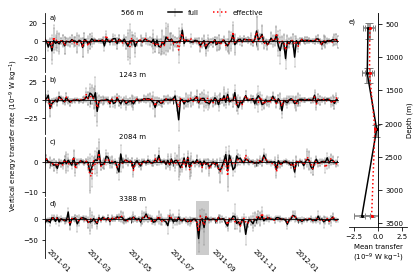

In [6]:
t0 = 734720
t1 = 734738
#####################################
m = ca

fig = plt.figure(figsize=(6.5, 4.5))
gs = GridSpec(m.N_levels*2, 2, width_ratios=[5, 1], hspace=0.1, wspace=0.06)
axs = [plt.subplot(gs[i*2:(i+1)*2, 0]) for i in range(m.N_levels)]
axp = plt.subplot(gs[:-1, 1])
axp.yaxis.set_ticks_position("right")
axp.yaxis.set_label_position("right")

for ax in axs[:-1]:
    ax.set_xticklabels([])

# Simplify plots
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_position("zero")

axp.spines["top"].set_visible(False)
axp.spines["left"].set_visible(False)
axp.spines["right"].set_position("zero")

# F = np.full_like(m.dudz, np.nan)
# F_alt = np.full_like(m.dudz, np.nan)

F_err = 1.96*utils.emean(m.errF_vert)
F_alt_err = 1.96*utils.emean(m.errF_vert_alt)

for lev in range(m.N_levels):

    tdt = m.tdt[:, lev]

    dudz = m.dudz[:, lev]
    dvdz = m.dvdz[:, lev]

    Tuw = m.Tuwg_int[:, lev]
    Tvw = m.Tvwg_int[:, lev]
    F_vert_alt = m.F_vert_alt[:, lev]

    uw = m.Cuwg_int[:, lev]
    vw = m.Cvwg_int[:, lev]
    ub = m.Cub_int[:, lev]
    vb = m.Cvb_int[:, lev]
    N_mean = m.N[:, lev]
    f = cc.f
    F_vert = m.F_vert[:, lev]

#     F[:, lev] = F_vert
#     F_alt[:, lev] = F_vert_alt

    # Useful numbers:
    print('Vertical transfer at {:1.0f} m is {:1.3e} +/- {:1.3e} W/kg'
          ''.format(-m.z[:, lev].mean(), F_vert.mean(), F_err[lev]))
    print('Alt vertical transfer at {:1.0f} m is {:1.3e} +/- {:1.3e} W/kg'
          ''.format(-m.z[:, lev].mean(), F_vert_alt.mean(), F_alt_err[lev]))

    axs[lev].set_xlim(tdt[0], tdt[-1])
    axs[lev].errorbar(tdt, 1e9*F_vert, yerr=1e9*1.96*m.errF_vert[:, lev], ecolor='grey', capsize=1,
                      color='k', label='full', elinewidth=0.4, capthick=0.4)
    axs[lev].errorbar(tdt, 1e9*F_vert_alt, yerr=1e9*1.96*m.errF_vert_alt[:, lev], ecolor='grey', capsize=1, color='r',
                      label='effective', ls=':', elinewidth=0.4, capthick=0.4)

    axs[lev].annotate(
        "{:1.0f} m".format(-m.z[:, lev].mean()),
        xy=(0.3, 1),
        xycoords="axes fraction",
        ha="center",
        va="center",
    )

axs[0].legend(loc=3, ncol=2, bbox_to_anchor=(0.4, 0.85), frameon=False)

# axs[0].set_ylim(-20, 20)
# axs[1].set_ylim(-20, 20)
# axs[2].set_ylim(-10, 10)
# axs[3].set_ylim(-35, 15)
# axs[4].set_ylim(-30, 30)

c = 1e9
yerr = np.abs(np.percentile(-ca.z, [10, 90], axis=0) + m.z.mean(axis=0))

axp.errorbar(
    c * m.F_vert.mean(axis=0),
    -m.z.mean(axis=0),
    xerr=c * F_err,
    yerr=yerr,
    fmt="o-",
    capsize=3,
    color='k',
    ecolor='grey',
    markersize=2,
)

axp.errorbar(
    c * m.F_vert_alt.mean(axis=0),
    -m.z.mean(axis=0),
    xerr=c * F_alt_err,
    yerr=yerr,
    fmt="o:",
    capsize=3,
    color='r',
    ecolor='grey',
    markersize=2,
)
axp.set_xlim(-3, 3)
axp.axvline(0, color="k", linewidth=1, alpha=0.5)
axp.set_xlabel("Mean transfer\n($10^{-9}$ W kg$^{-1}$)")
axp.set_ylabel("Depth (m)")
axp.invert_yaxis()

cfs.ylabel("Vertical energy transfer rate ($10^{-9}$ W kg$^{-1}$)", fig, axs[1], axs[2], -0.08)
# axs[2].set_ylabel("Vertical energy transfer rate ($10^{-9}$ W kg$^{-1}$)")
cfs.axes_labels(
    fig,
    axs,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.01,
    dy=-0.02,
)
cfs.axes_labels(
    fig,
    axp,
    i0=4,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.0,
    dy=-0.03,
)

axs[3].fill_betweenx(
    axs[3].get_ylim(),
    utils.datenum_to_datetime(t0),
    utils.datenum_to_datetime(t1),
    color="k",
    alpha=0.2,
    linewidth=0,
)

plt.setp(
    axs[-1].xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor"
)
axs[-1].tick_params(axis="x", which="major", pad=25)

if save_figs:
    fig_name = "vertical_energy_flux_all_levels.pdf"
    fig.savefig(os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0)
    fig_name = "vertical_energy_flux_all_levels.png"
    fig.savefig(os.path.join(fsd, fig_name), dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()

<a id="time_series_slow_eddies"></a>

# Energy transfer in frequency

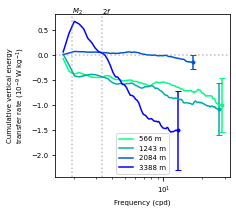

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(3.125, 3))

ax.set_ylabel('Cumulative vertical energy\ntransfer rate ($10^{-9}$ W kg$^{-1}$)')
ax.set_xlabel('Frequency (cpd)')

F_err = utils.emean(ca.errF_vert)

colors = plt.cm.winter_r(np.linspace(0, 1, cw.N_levels))

for lev in range(ca.N_levels):
    fmin = fcor = np.abs(cc.f) / (np.pi*2)
    fmax = ca.N[:, lev].mean()/(np.pi*2)
    use = (cw.freq > fmin) & (cw.freq < fmax)
    freq = cw.freq[use]
    df = np.diff(freq)[0]

    uw = cw.Cuwg[use, :, lev].real
    vb = cw.Cvb[use, :, lev].real
    vw = cw.Cvwg[use, :, lev].real
    ub = cw.Cub[use, :, lev].real
    N = ca.N[:, lev]
    dudz = ca.dudz[:, lev]
    dvdz = ca.dvdz[:, lev]

    Especdu = -(uw - vb * cc.f / N ** 2)*dudz
    Especdv = -(vw + ub * cc.f / N ** 2)*dvdz
    Especv = Especdu + Especdv

#     ax.plot(freq/fcor, Especdu.mean(axis=-1)*df, 'r.-', label='dudz')
#     ax.plot(freq/fcor, Especdv.mean(axis=-1)*df, 'b.-', label='dvdz')
    csum = np.cumsum(1e9*Especv.mean(axis=-1)*df)
    ax.semilogx(freq*84600, csum, label='{:1.0f} m'.format(-ca.z[:, lev].mean()), color=colors[lev])
    ax.errorbar(freq[-1]*86400, csum[-1], fmt='.', yerr=1.96*1e9*F_err[lev], color=colors[lev], capsize=3)

ax.legend()

ax.axvline(M2, color='grey', ls=':', alpha=0.5)
ax.axvline(2*fcor*86400, color='grey', ls=':', alpha=0.5)
ax.axhline(0, color='grey', ls=':', alpha=0.5)

ax.annotate('$M_2$', xy=(M2, ax.get_ylim()[1]))
ax.annotate('$2f$', xy=(2*fcor*86400, ax.get_ylim()[1]))

if save_figs:
    fig.savefig(
        os.path.join(fsd, "cum_vert_transfer.pdf"),
        bbox_inches="tight",
        pad_inches=0.01,
        dpi=300,
    )
    fig.savefig(
        os.path.join(fsd, "cum_vert_transfer.png"),
        bbox_inches="tight",
        pad_inches=0.01,
        dpi=300,
    )

<a id="topo_map"></a>

# Anatomy of high vertical flux event

### Level 3

z mean -3392.1759226764675 m


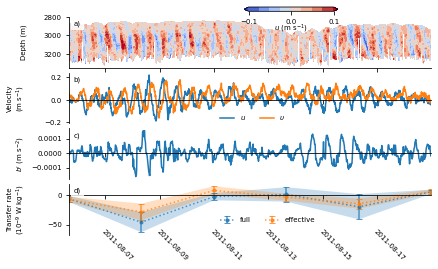

In [13]:
## first lev 4 big spike negative
t0 = 734718
t1 = 734736
lev = 3
levr = 10

m = ca
# Split up arrays
tm = ca.t[:, lev]
use = (cc.t[:, levr] > t0) & (cc.t[:, levr] < t1)
usem = (tm > t0) & (tm < t1)
usea = (ADCP.dates > t0) & (ADCP.dates < t1)

# Energy stuff
# tdt = ca.tdt[use, lev]
tdtm = ca.tdt[usem, lev]

dudz = m.dudz[usem, lev]
dvdz = m.dvdz[usem, lev]
uw = m.Cuwg_int[usem, lev]
vw = m.Cvwg_int[usem, lev]
ub = m.Cub_int[usem, lev]
vb = m.Cvb_int[usem, lev]

N_mean = m.N[usem, lev]

EP0 = -(uw - cc.f * vb / N_mean ** 2)
EP1 = -(vw + cc.f * ub / N_mean ** 2)

F_vert = ca.F_vert[usem, lev]
F_vert_alt = ca.F_vert_alt[usem, lev]
errF_vert = ca.errF_vert[usem, lev]
errF_vert_alt = ca.errF_vert_alt[usem, lev]

urhi = cc.u[use, levr]
vrhi = cc.v[use, levr]
brhi = -9.81 * cc.gamman_hi[use, levr] / cc.gamman_lo[use, levr]
zr = cc.z[use, levr]
tr = cc.tdt[use, levr]

print("z mean {} m".format(zr.mean()))

# ADCP stuff
ua = ADCP.u_bp[:, usea]
# va = ADCP.v_bp[:, usea]
za = ADCP.z[:, usea]
ta = np.tile(utils.datenum_to_datetime(ADCP.dates)[np.newaxis, usea], (ADCP.z.shape[0], 1))

fig, axs = plt.subplots(
    4, 1, sharex=True, figsize=(6.5, 4), gridspec_kw={"hspace": 0.1}
)

C = axs[0].contourf(ta, za, ua, np.linspace(-0.1, 0.1, 2**3+1), cmap='coolwarm', extend='both')
axs[0].set_ylim(3350, 2800)
cb = plt.colorbar(C, cax=fig.add_axes((0.5, 0.9, 0.2, 0.015)), orientation='horizontal')
cb.set_label('$u$ (m s$^{-1}$)', labelpad=-2)
cb.set_ticks([-0.1, 0, 0.1])

axs[1].set_xlim(tdtm[0], tdtm[-1])
axs[1].plot(tr, urhi, label="$u$")
axs[1].plot(tr, vrhi, label=r"$\upsilon$")
axs[1].legend(loc=3, bbox_to_anchor=(0.4, -0.1), ncol=2, frameon=False)

axs[2].plot(tr, brhi)

c = 1e9
axs[3].errorbar(tdtm, c * F_vert, yerr=c*errF_vert, label='full', capsize=3, alpha=.75, ls=':', marker='o', markersize=3)
axs[3].errorbar(tdtm, c * F_vert_alt, yerr=c*errF_vert_alt, label='effective', capsize=3, alpha=.75, ls=':', marker='o', markersize=3)
axs[3].fill_between(tdtm, c * (F_vert - errF_vert), c * (F_vert + errF_vert), alpha=0.25)
axs[3].fill_between(tdtm, c * (F_vert_alt - errF_vert_alt), c * (F_vert_alt + errF_vert_alt), alpha=0.25)
axs[3].legend(loc=3, bbox_to_anchor=(0.4, 0.1), ncol=2, frameon=False)

axs[0].set_ylabel('Depth (m)')
axs[1].set_ylabel("Velocity\n(m s$^{-1}$)")
axs[2].set_ylabel("$b^\prime$ (m s$^{-2}$)")
# axs[2].set_ylabel(r"$\frac{\partial u}{\partial z}$ ($10^{-6}$ s$^{-1}$)")
# axs[3].set_ylabel("Stress\n($10^{-4}$ m$^{2}$ s$^{-1}$)")
axs[3].set_ylabel("Transfer rate\n($10^{-9}$ W kg$^{-1}$)")

cfs.axes_labels(
    fig,
    axs,
    bbox=dict(facecolor="w", edgecolor="w", boxstyle="square", alpha=0.8),
    dx=0.01,
    dy=-0.03,
)

# Simplify plots
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
for ax in axs[1:]:
    ax.spines["bottom"].set_position("zero")

fig.align_ylabels(axs)
plt.setp(
    axs[-1].xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor"
)
axs[-1].tick_params(axis="x", which="major", pad=30)

if save_figs:
    fig.savefig(
        os.path.join(fsd, "vert_zoom_lev3.pdf"),
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )
    fig.savefig(
        os.path.join(fsd, "vert_zoom_lev3.png"),
        bbox_inches="tight",
        pad_inches=0,
        dpi=300,
    )